# Music Lyrics by Decade Analysis

# Index
1. [Research Question](#research) <br>
2. [The Data and Preprocessing](#preprocessing) <br>
   2.1 [Libraries](#libraries) <br>
   2.2 [Importing the Data](#importdata)<br>
   2.3 [Data Exploration and Housekeeping](#housekeeping)<br>
   2.4 [Clean and Lemmatize](#lemma)<br>
   2.5 [Downsampled Dataset](#downsample)<br>
   2.6 [PMI and Collocations](#pmi)<br>
3. [Tokens and TFIDF Analysis](#tfidf)<br>
4. [3D Representation](#3D)<br>
5. [W2V Embeddings](#w2v)<br>
6. [Doc2Vec Embeddings and Gender Focus](#doc2vec)<br>
7. [Topic Model](#topic)

# <a name="research"></a> Research Question

The aim of this project is to analyse the lyrics of songs from different decades to uncover systematic changes in the language used and topics treated, and to unveil to what extent lyrics reflect how the meaning of certain words has evolved over time, with a focus on the role of gender in music.

<div class="alert alert-block alert-danger">
<b>Please Note:</b>
Many operations here are subjected to stochasticity, therefore it is recommended to look at the presented output and the related comments before running the cells. 
</div>

# <a name="preprocessing"></a> Data and Preprocessing

For this project I created a new dataset, which is mainly constituted by the "[Audio features and lyrics of Spotify songs](https://www.kaggle.com/datasets/imuhammad/audio-features-and-lyrics-of-spotify-songs)" dataset available on Kaggle, to which I have added a few thousand songs from the [Music Dataset: 1950 to 2019](https://www.kaggle.com/datasets/saurabhshahane/music-dataset-1950-to-2019) whose lyrics were scraped through the Genius API, given that in the original dataset songs prior to the 2000s were heavily underrepresented, and the latter was missing the raw original lyrics. This final dataset still needs preprocessing, and comprises around 20000 songs, all available on Spotify, each with lyrics, information regarding their genre, language, year of realease, as well as some audio features provided by the Spotify API. I will mainly concentrate on songs in English, published from the 60s to the 2010s, and specifically on extracting useful insights from the "lyrics" feature.

## <a name="libraries"></a> Import Libraries

In [2]:
import re
import spacy
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
from mpl_toolkits.mplot3d import Axes3D
from gensim.models.phrases import Phrases
from gensim.models import AuthorTopicModel
from collections import Counter, defaultdict
from sklearn.decomposition import TruncatedSVD
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
warnings.filterwarnings("ignore", category=FutureWarning)

## <a name="importdata"></a> Import Dataset

I will start importing the dataset, selecting English songs only, and making sure there are no null entries nor duplicated lyrics.

In [3]:
# Import data

songs = pd.read_csv("data/nlp_songs_dataset").rename(columns = {"Unnamed: 0": "ID"})
songs.head()

,ID,track_name,track_artist,lyrics,genre,language,release_date,danceability,energy,loudness,acousticness,instrumentalness,valence
0,0,Love Scars,Trippie Redd,"ayy lil 14, yeah you used to say you in love i...",rap,en,2017-05-14,0.659000,0.614000,-7.320000,0.000404,0.000000,0.260000
1,1,Kiss It Better - KAYTRANADA Edition,Rihanna,"kiss it, kiss it better, baby kiss it, kiss it...",r&b,en,2016-06-01,0.854000,0.498000,-7.922000,0.022900,0.000212,0.343000
2,2,Happy,Oh Wonder,never thought i'd be happy never thought i'd b...,pop,en,2020-01-03,0.698000,0.516000,-8.472000,0.454000,0.000000,0.516000
3,3,never dreamed you'd leave in summer,joan baez,i never dreamed you'd leave in summer i though...,pop,en,1975,0.181198,0.232208,0.604928,0.764056,0.000000,0.153957
4,4,Did My Best,The Voidz,let me tell you a story'bout the hazy good old...,rock,en,2019-12-13,0.533000,0.794000,-4.687000,0.154000,0.888000,0.623000


## <a name="housekeeping"></a> Data Exploration and Housekeeping

In [4]:
# COUNTING TOTAL NUMBER OF TOKENS
words_start = songs.lyrics.tolist()
starting_words_count = CountVectorizer(analyzer="word",
                                 ngram_range= (1,1),
                                 min_df = 1,
                                 max_df = 1.0)

words_counter = starting_words_count.fit_transform(words_start)

In [5]:
# Select English songs, and make sure there are no null entries

songs = songs[songs["language"] == "en"].reset_index(drop = True)

assert songs.isna().sum().all() == 0

print("Total number of songs:", len(songs))
print("Total number of unique words:", len(starting_words_count.get_feature_names()) )
print()
print("All columns:", end = " ")
for i in songs.columns.values:
    if i == songs.columns.values[-1]:
        print(f"{i}.")
    else:
        print(i, end = ", ")       
print()

# Numeric summary stats
num = ["int64", "float64"]
print("Summary statistics for numeric variables (i.e. Spotify API audio-features):")
songs.describe(include = num).iloc[1:,1:] # excluded count as it wasn't providing useful info, as well as the ID statistics

Total number of songs: 17218
Total number of unique words: 58428

All columns: ID, track_name, track_artist, lyrics, genre, language, release_date, danceability, energy, loudness, acousticness, instrumentalness, valence.

Summary statistics for numeric variables (i.e. Spotify API audio-features):


,danceability,energy,loudness,acousticness,instrumentalness,valence
mean,0.595211,0.661695,-5.027566,2.104718e-01,0.051106,0.514075
std,0.167425,0.205288,4.159289,2.576258e-01,0.160492,0.234570
min,0.005415,0.016700,-34.283000,4.317273e-07,0.000000,0.000010
25%,0.486000,0.522000,-7.625750,1.510000e-02,0.000000,0.331000
50%,0.607000,0.687000,-5.301000,9.060000e-02,0.000024,0.513603
75%,0.718000,0.828000,-1.477250,3.263045e-01,0.003200,0.697000
max,0.979000,1.000000,1.275000,1.000000e+00,0.975709,0.990000


In [6]:
# Non-numeric summary stats
obj = ["object"]
print("Summary statistics for non-numeric variables:")
songs.describe(include = obj)

Summary statistics for non-numeric variables:


,track_name,track_artist,lyrics,genre,language,release_date
count,17218,17218,17218,17218,17218,17218
unique,15814,5983,17103,6,1,3260
top,You,Queen,unknown,pop,en,1968
freq,10,97,16,5981,17218,176


There seem to be lyrics which are repeated, as well as many recurring titles, so I will drop them.

In [7]:
duplicated_lyrics = songs.groupby(by = "lyrics").count()[["ID"]]
duplicated_lyrics = duplicated_lyrics.rename(columns={"ID":"count"}).sort_values(by ="count",ascending=False)

print("There are",len(duplicated_lyrics[duplicated_lyrics["count"] > 1]), "song lyrics repeated more than once.")
print(f"Most recurring song lyrics is: \"{duplicated_lyrics.index[0]}\" appearing",duplicated_lyrics.iloc[0,0], "times.")

There are 34 song lyrics repeated more than once.
Most recurring song lyrics is: "unknown" appearing 16 times.


In [8]:
duplicated_titles = songs.groupby(by = "track_name").count().rename(columns={"ID": "count"})[["count"]]
top = duplicated_titles.sort_values(by = "count", ascending = False).head()

print(f"Most recurring song title \"{top.index[0]}\" appears {top.iloc[0,0]} times in this dataset, and was performed by:")
artists = songs[songs["track_name"] == top.index[0]].track_artist.unique()
[print(x) for x in artists]
      
top

Most recurring song title "You" appears 10 times in this dataset, and was performed by:
Lost Kings
Jesse Powell
Majid Jordan
Lloyd
WildVibes
Charlie Who?
Seinabo Sey
Five Finger Death Punch
dodie
Boytronic


,count
track_name,
You,10
Heaven,10
Stay,9
Alone,9
Forever,8


In [9]:
# Drop repeated lyrics and repeated pairs of title + artist

songs = songs.drop_duplicates(subset = "lyrics")
songs = songs.drop_duplicates(subset = ["track_name", "track_artist"])
print("Number of remaining songs:", len(songs))

Number of remaining songs: 17103


Given the aim of this research, I want to retrieve the decade of each song from their release date.

In [10]:
# Extract decade each song is from

def decade(x):
    dec = str(x)[:3]
    d = {"195": "50s", "196": "60s", "197": "70s", "198": "80s", "199": "90s", "200": "00s", "201":"10s", "202": "20s"} 
    return d[dec]

songs["decade"] = songs["release_date"].apply(lambda x: decade(x))

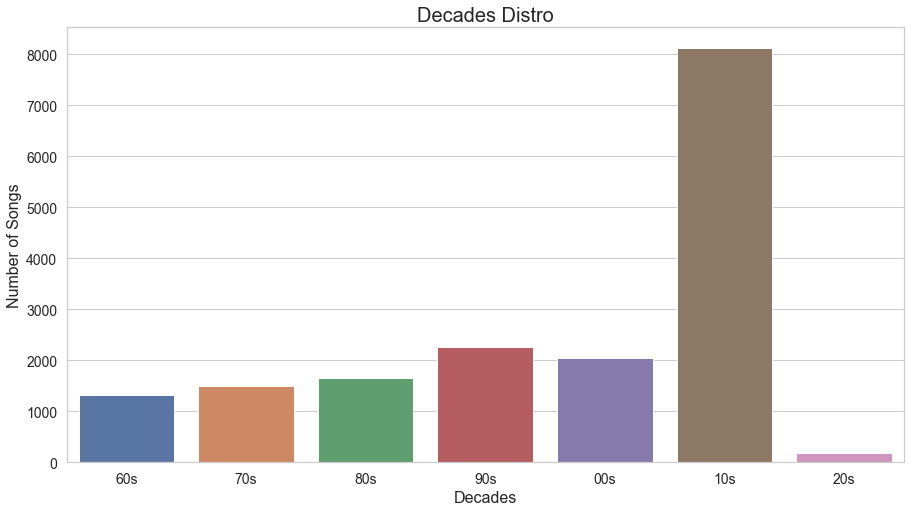

In [11]:
# Plot how songs from various decades are distributed

decades_distro = songs.groupby(by = "decade").count()[["ID"]].reset_index().rename(columns = {"ID": "count"})

sns.set(rc={'figure.figsize':(15,8)})
sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = "decade", y ="count", data = decades_distro,order=["60s", "70s", "80s", "90s", "00s", "10s", "20s"],
                 dodge=False)

plt.legend([],[], frameon=False)
plt.xlabel('Decades', fontsize=16);
plt.ylabel('Number of Songs', fontsize=16);
plt.title("Decades Distro", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
print()

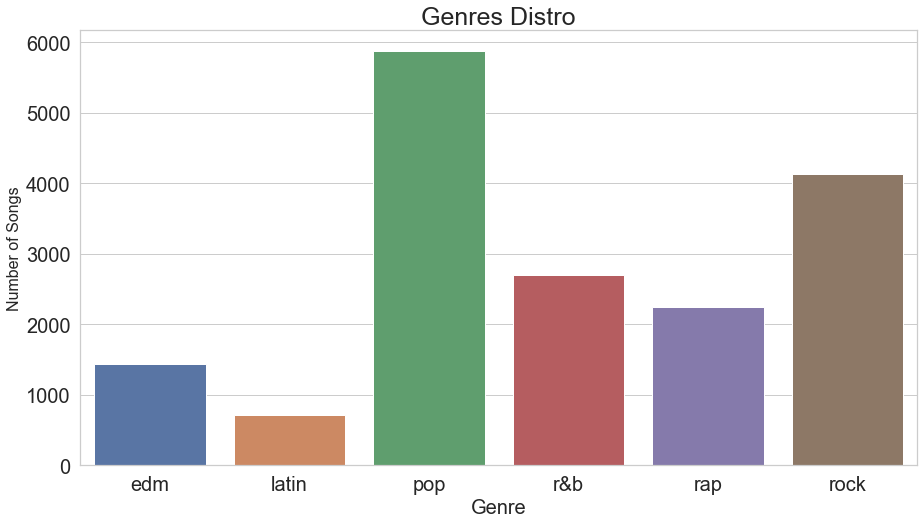

In [12]:
# Plot how genres are distributed 

dec_dis = songs.groupby(by = "genre").count()[["ID"]].reset_index().rename(columns = {"ID": "count"})

sns.set(rc={'figure.figsize':(15,8)}, font_scale = 80000)
sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = "genre", y = "count", data = dec_dis, dodge=False)

plt.legend([],[], frameon=False)
plt.xlabel('Genre', fontsize=20);
plt.ylabel('Number of Songs', fontsize=16);
plt.title("Genres Distro", fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
print()

In [13]:
# Finally, we can see the distribution of the various genres in the different decades

genres_per_decade = songs.groupby(by = ["decade", "genre"]).count().reset_index()

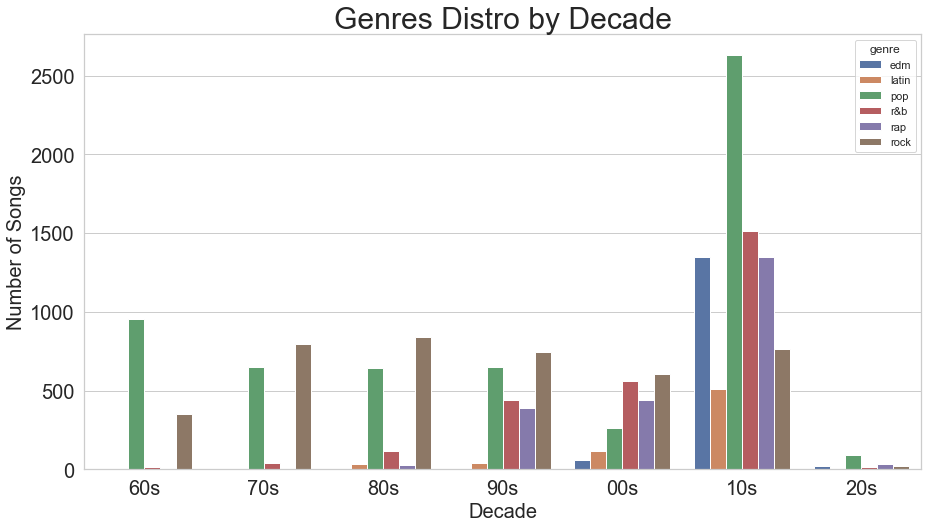

In [14]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_theme(style = "whitegrid")

ax = sns.barplot(x = "decade", y = "ID", data = genres_per_decade,
                 hue="genre",order=["60s", "70s", "80s", "90s", "00s", "10s", "20s"], dodge=True)

plt.xlabel('Decade', fontsize=20);
plt.ylabel('Number of Songs', fontsize=20);
plt.title("Genres Distro by Decade", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
print()

As it could be expected, genres like EDM and Rap are basically not appearing in the earlier decades.

## <a name="lemma"></a> Clean and Lemmatize

- Firstly I use some very simple regular expressions to exclude some punctuation and useless spaces from the songs lyrics;
- Then I generate a new "lemma" column storing the lemmas of content words to minimize the variance of terms.

In [15]:
nlp = spacy.load('en_core_web_sm')
stopwords_ = set(stopwords.words("english"))

In [16]:
def clean(x):
    """
    This function cleans any string input according to the following steps:
        - bringing the lyrics to lower case;
        - removing what is included in curly brackets (often "Hook", "Verse" etc.);
        - removing some non informative punctuation and empty spaces.
    """
    
    x = str(x).lower() # lower lyrics
    x = re.sub(r"\{.*?\}", "", x) # remove curly brackets and what's inside
    x = re.sub(r"\(|\)|\"|\.\.\.|\\", "", x) # remove backslashes, parentheses, quotation marks, "..."
    x = re.sub(r"\-\-|\s\s+", " ", x) # replace "--" and empty spaces with a single space

    return x

songs.lyrics = songs.lyrics.apply(lambda x: clean(x))

In [17]:
# ATTENTION: it might take some time, so please run directly following cell to import already lemmatized dataset.

def lemma(text):
    """
    This function lemmatizes any string input, i.e. replaces any word with its dictionary entry, excluding non informative
    words that are not nouns, verbs, adjectives, adverbs or pronouns, so that only useful "content words" are included.
    """
    
    return ' '.join([word.lemma_
            for word in nlp(text)
            if word.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'} and not word.text in stopwords_])

# This is the function and how it was applied
#songs["lemma"] = songs["lyrics"].apply(lambda x: lemma(x))

In [21]:
songs = pd.read_csv("data/nlp_songs_lemmatized").drop(columns = ["Unnamed: 0"])

songs.describe(include = "object")

,track_name,track_artist,lyrics,lemma,genre,language,release_date,decade
count,17103,17103,17103,17103,17103,17103,17103,17103
unique,15725,5978,17103,17073,6,1,3260,8
top,You,Queen,"ayy lil 14, yeah you used to say you in love i...",wise man say fool rush help fall love stay sin...,pop,en,1968,10s
freq,10,97,1,2,5877,17103,155,8122


Note: this is also a way to standardize the lyrics, which could appear multiple times in the dataset in slightly different forms, and allows to reveal further duplicates, so I will drop na entries as well as newly emerged duplicates thanks to the "standardization" of the lyrics.

In [22]:
songs = songs.dropna().reset_index(drop = True)
songs = songs.drop_duplicates(subset = "lemma")

In [23]:
# See result of this simple preprocessing

index = random.randint(0,len(songs))
print("Index:",index)
print()
print("Lyrics:",songs["lyrics"][index])
print()
print("Lemmas:",songs["lemma"][index])

Index: 10875

Lyrics: changing, moving in a circle i can see your face in all of my dreams smiling, laughing from the shadows when i hear your voice i know what it means i know it doesn't matter just how hard i try you're all the reason for my life disillusion, disillusion's all you left for me how can i forget you when my world is breaking down? you're all i had, you're all i want disillusion, disillusions now, that's all i have wishing, hoping, chasing shadows did i see your face somewhere in the crowd? thinking, wondering, what you're doing i can't stop myself from crying out loud they say my wound will heal and only leave a scar but then, they'd never shared our love disillusion, disillusion's all you left for me how can i forget you when my world is breaking down? you're all i had, you're all i want disillusion, disillusions now, that's all i have disillusion, disillusions now, that's all i have

Lemmas: change move circle see face dream smile laugh shadow hear voice know mean kno

Now we can count how many different words and lemmas remain, considering of course that only content words were kept in the lemmas.<br> This is done using sklearn's CountVectorizer function, which creates for each document (i.e., song lyrics) a sparse vector containing information about the frequency of each token.

In [77]:
words = songs.lyrics.tolist()
lemmas = songs.lemma.tolist()

lemmas_count_vectorizer = CountVectorizer(analyzer="word",
                                 ngram_range= (1,1),
                                 min_df = 1,
                                 max_df = 1.0)

lemmas_counter = lemmas_count_vectorizer.fit_transform(lemmas)

words_count_vectorizer = CountVectorizer(analyzer="word",
                                 ngram_range= (1,1),
                                 min_df = 1,
                                 max_df = 1.0)

words_counter = words_count_vectorizer.fit_transform(words)

print("Total number of unique words:",len(words_count_vectorizer.get_feature_names()))
print("Total number of unique lemmas:",len(lemmas_count_vectorizer.get_feature_names()))

Total number of unique words: 58428
Total number of unique lemmas: 48436


## <a name="downsample"></a> Downsampled Dataset

Given the quite uneven distribution of songs across decades, I will also keep a more balanced dataset with ~2000 random songs per decade, in order to still mantain a sufficiently large number of songs ranging from the 60s to the 2010s.

In [24]:
# Constitution of a downsampled more balanced dataset

_60s = songs[songs["decade"] == "60s"]
_70s = songs[songs["decade"] == "70s"]
_80s = songs[songs["decade"] == "80s"]
_90s = songs[songs["decade"] == "90s"][:2000]
_00s = songs[songs["decade"] == "00s"][:2000]
_10s = songs[songs["decade"] == "10s"][:2000]

songs_bal = pd.concat([_60s, _70s, _80s, _90s, _00s, _10s], axis = 0).sample(frac = 1).reset_index(drop = True)

print("Total number of songs:", len(songs_bal))

Total number of songs: 10459


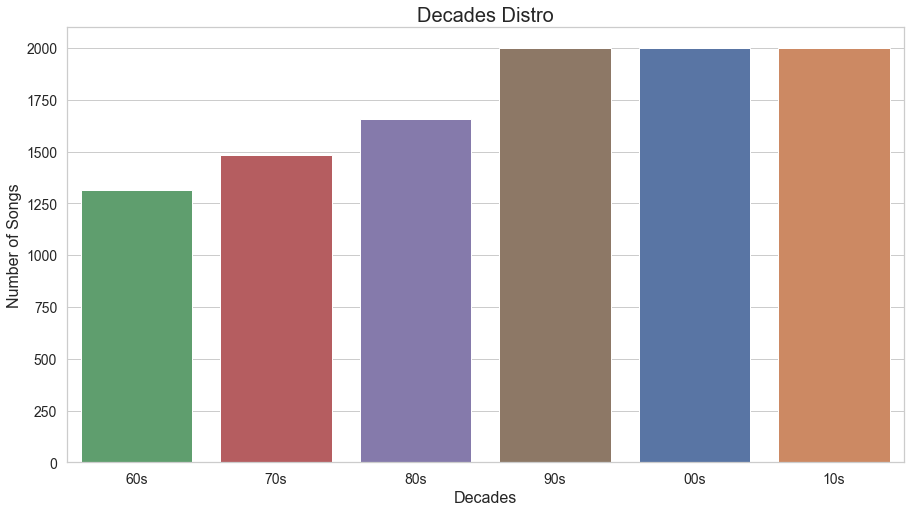

In [79]:
# Now songs are more evenly distributed across decades

dec_dis = songs_bal.groupby(by = "decade").count()[["ID"]].reset_index()

sns.set(rc={'figure.figsize':(15,8)}, font_scale = 80000)
sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = "decade", y ="ID", data = dec_dis, order=["60s","70s", "80s", "90s", "00s", "10s"],
                 hue="decade", dodge=False)

plt.legend([],[], frameon=False)
plt.xlabel('Decades', fontsize=16);
plt.ylabel('Number of Songs', fontsize=16);
plt.title("Decades Distro", fontsize=20)
plt.tick_params(axis='both', which= 'major', labelsize=14)
print()

## <a name="pmi"></a>PMI and Collocations

Finally, I used point mutual information to retrieve collocations, i.e. two tokens often appearing together, which should hence be considered as a single token.<br> However, despite the collocations in the lyrics were somewhat interesting, the lemmas collocations were very uninformative and often meaningless, so I decided not to replace them in the text.

In [23]:
# create list of tokens from the "lyrics" column of the "songs" df
lyrics = songs["lyrics"].apply(lambda x: x.split())
lyrics = [word for sentence in lyrics for word in sentence]

In [24]:
# find collocations and dtore them in the "collocations_lyrics" set
finder = BigramCollocationFinder.from_words(lyrics)
bgm = BigramAssocMeasures()
score = bgm.mi_like

collocations_lyrics = set({" ".join(bigram): scoring for bigram, scoring in finder.score_ngrams(score) if scoring > 40})

In [22]:
# repeat the process above for the "lemmas" column of the "songs" df
lemmas = songs["lemma"].apply(lambda x: x.split())
lemmas = [word for sentence in lemmas for word in sentence]

In [26]:
finder = BigramCollocationFinder.from_words(lemmas)
bgm = BigramAssocMeasures()
score = bgm.mi_like

collocations_lemmas = set({" ".join(bigram): scoring for bigram, scoring in finder.score_ngrams(score) if scoring > 40})

In [25]:
# example of a resulting set
collocations_lyrics

{'1, 2,',
 'a little',
 'and i',
 'boom boom',
 'burn, burn,',
 'but i',
 'come on,',
 'da, da,',
 'doh, doh,',
 "don't know",
 "don't wanna",
 'doo-doo-doo-doo doo-doo-doo-doo,',
 'du du',
 'dum dum',
 'each other',
 'i am',
 'i can',
 "i can't",
 "i don't",
 'i got',
 'i know',
 'i need',
 'i wanna',
 'i want',
 'i was',
 "i'll be",
 "i've been",
 'if you',
 'in my',
 'in the',
 'know what',
 'kyrie eleison,',
 'la la',
 'la, la,',
 'laffy taffy',
 'let me',
 'like a',
 'little bit',
 'look at',
 'low, low,',
 'make it',
 'more than',
 'my heart',
 'my mind',
 'my, my,',
 'na na',
 'na, na,',
 'nah, nah,',
 'no, no,',
 'noodle soup',
 'oh oh',
 'oh, oh,',
 'on my',
 'on the',
 'ooh, ooh,',
 'ooh-woah, ooh-woah',
 'out of',
 'pose, pose,',
 'tell me',
 'the way',
 'this is',
 'to be',
 'to the',
 'too much',
 'used to',
 'wo! wo!',
 'work, work,',
 'yeah, yeah',
 'yeah, yeah,',
 'you know',
 '¡hola! ¡hola!'}

In [47]:
# Function to replace collocations that I ultimately prefered not to use
def replace_collocations(s, collocations):
    """
    This function replaces each collocation as a single token.
    """
    s = s.split()
    i = 0
    while i <= len(s) - 2:
        if str(s[i] + " " + s[i+1]) in collocations:
            s[i] = s[i] + "_" + s.pop(i+1)
        i += 1
    s = " ".join(s)
    return s
#songs.lemma = songs.lemmas.apply(lambda x: replace_collocations(x, collocations_lemmas))

## <a name="tfidf"></a> Tokens and TFIDF Analysis

I will start looking at the [TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) as a measure of "importance" of words in this representative sample of songs, in the hopes that it might help extracting some first information about the differences between the vocabulary used by the lyrics across the different decades. This was done through sklearn's TfidfVectorizer function.

In [25]:
# Let's see which tokens are most common / important

ngram_range = (1,2)
min_df = 0.001
max_df = 0.75

tokens = songs.lemma.tolist() # alternatively songs.lyrics.tolist()

# make a function as I will use it again later
def vectorize_sparse(tokens, ngram_range, min_df, max_df, how = None, analyzer = "word"):
    """
    This function returns a dataframe object with sparse information about term frequency, TFIDF and IDF of each token appearing
    in the input text.
    """

    count_vectorizer = CountVectorizer(analyzer=analyzer,
                                 ngram_range= ngram_range,
                                 min_df = min_df,
                                 max_df = max_df,
                                 stop_words= 'english')

    X_count = count_vectorizer.fit_transform(tokens)
    
    if how == "count":
        return X_count

    tfidf_vectorizer = TfidfVectorizer(analyzer= analyzer,
                                       ngram_range= ngram_range, 
                                       min_df = min_df, 
                                       max_df = max_df, 
                                       stop_words= 'english', 
                                       sublinear_tf=True)

    X_tfidf = tfidf_vectorizer.fit_transform(tokens)
    
    if how == "tfidf":
        return X_tfidf
    
    sparse_data = pd.DataFrame(data={'word': count_vectorizer.get_feature_names(),
                        'tfidf': X_tfidf.sum(axis=0).A1,
                        'term_frequency': X_count.sum(axis=0).A1,
                        'idf': tfidf_vectorizer.idf_
                   }).sort_values(["tfidf",'term_frequency', 'idf'], ascending= False).reset_index(drop = True)
    
    return sparse_data

In [81]:
sparse_data = vectorize_sparse(tokens, ngram_range, min_df, max_df)

Now we can plot the term frequency distribution and see that, as usual, it follows a power function shape, and then retrieve the most "important" tokens sorting them by TFIDF instead.

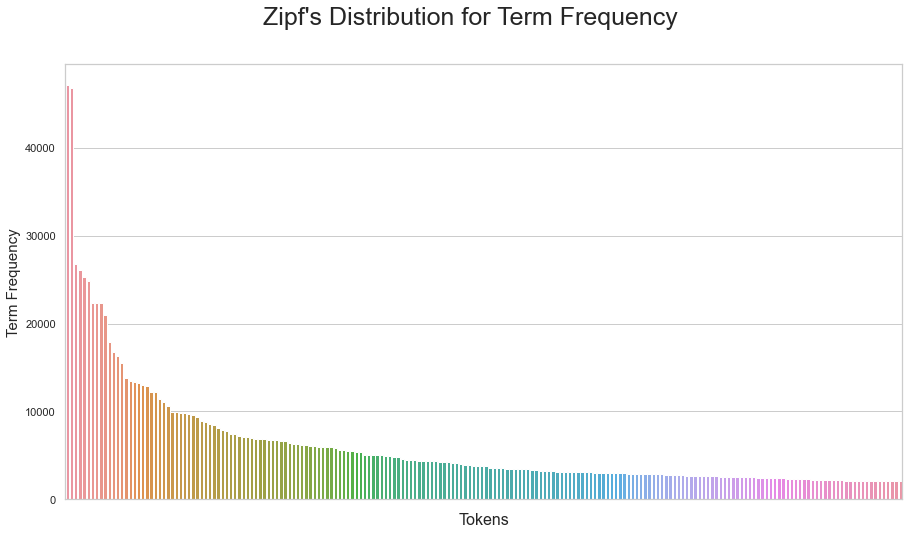

In [82]:
# plot term frequency Zipf's distribution

fig, ax = plt.subplots(figsize=(15, 8))
sns.set_theme(style = "whitegrid")
sns.barplot(x = "word", y ="term_frequency", data = sparse_data.sort_values(["term_frequency"], ascending = False).iloc[:200,:],
            ax = ax)

#ax.set_xticklabels(ax.get_xticklabels(), rotation= 30, ha="right")
plt.xlabel('Tokens', fontsize=16);
plt.ylabel(ylabel = "Term Frequency", fontsize = 15);
plt.suptitle("Zipf's Distribution for Term Frequency", fontsize=25)
ax.set(xticklabels=[])
print()

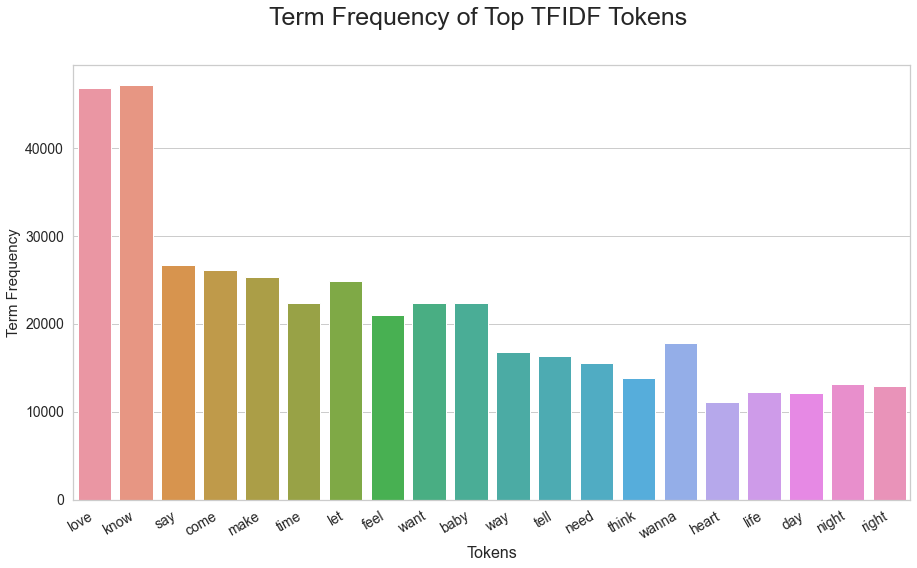

In [83]:
# Let's see top 20 most "common" tokens (sorted by tfidf)

fig, ax = plt.subplots(figsize=(15, 8))
sns.set_theme(style = "whitegrid")
sns.barplot(x = "word", y ="term_frequency", data = sparse_data.iloc[:20,:], ax = ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation= 30, ha="right")
plt.xlabel('Tokens', fontsize=16);
plt.ylabel(ylabel = "Term Frequency", fontsize = 15);
plt.suptitle("Term Frequency of Top TFIDF Tokens", fontsize=25)
plt.tick_params(axis='both', which= 'major', labelsize=14)
print()

As it could be expected, they seem to be mostly generic words probably appearing in love songs. Remeber that the dataset is very unbalanced, and there are many more recent songs which are probably affecting the TFIDF of the top words, therefore it would make sense to look at the top words per decade independently.

In [27]:
# Generate a df concatanating the sparse representations of all the genres, but keeping only the top 50 TFIDF tokens per decade

def tokens_by_decade(songs, limit = None):
    """
    This function creates a sparse representation of lyrics split by decade, concatanating the resulting dataframes in a single
    object.
    The limit argument specifies the top n words to keep for each decade.
    """
    
    decades_tokens = pd.DataFrame()
    for i in songs.decade.unique():
        if i == "50s" or i == "20s": # excluding 50s and 2020s that have very few songs
            pass
        else:
            tokens = songs[songs["decade"] == i].lemma.tolist()
            vect = vectorize_sparse(tokens, ngram_range, min_df, max_df)
            vect = vect.iloc[:limit, :] # can specify a limit of how many tokens per decade to store
            vect["decade"] = i
            decades_tokens = pd.concat([decades_tokens, vect])
    
    return decades_tokens

In [28]:
decades_tokens = tokens_by_decade(songs, limit = 50)

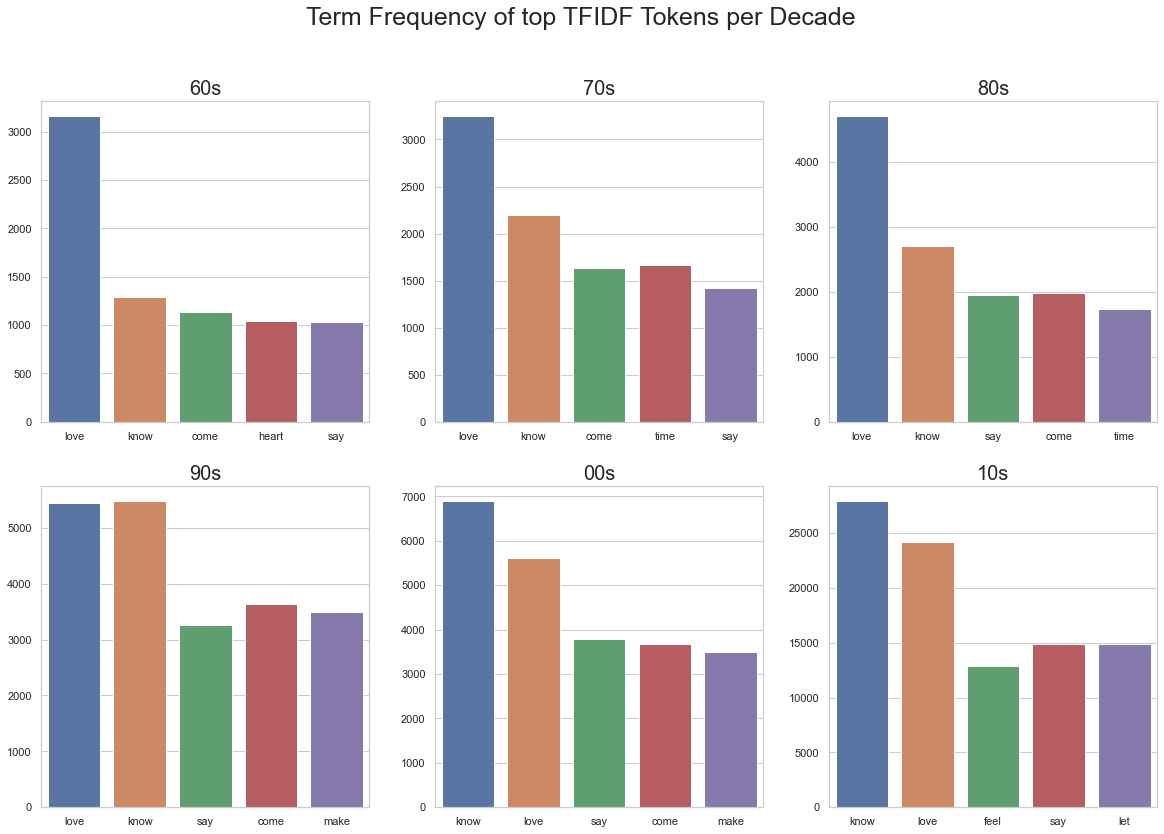

In [85]:
# Plot the term frequency for the top 5 tokens for TFIDF, split by decade
sns.set(rc={'figure.figsize':(20, 13)})
sns.set_theme(style = "whitegrid")

fig, axs = plt.subplots(ncols=3, nrows=2)
col = 0
for n,i in enumerate(["60s", "70s", "80s", "90s", "00s", "10s"]):
    if n>2:
        n -= 3
        col = 1
    bar = sns.barplot(x='word', y='term_frequency', data = decades_tokens[decades_tokens["decade"] == str(i)].iloc[:5,:],
                ax=axs[col][n])
    bar.axes.set_title(str(i), fontsize=20)
    bar.set_xlabel("")
    bar.set_ylabel("")
fig.suptitle('Term Frequency of top TFIDF Tokens per Decade', fontsize=25)
print()

It doesn't seem like there are many insights to be extracted yet, although it is interesting to see that the most common words in songs have remained roughly the same across 60 years, despite the undoubted changes music has gone through since the 60s. However, there are a few "outliers", i.e. words among the top 50 TFIDF in specific decades but missing from the top words of the others, that can be extracted through the following operations.

In [86]:
# extracting tokens from the top 50 TFIDF not appearing among the top tokens of the other decades 
d = defaultdict(list)
for i in ["60s", "70s", "80s", "90s", "00s", "10s"]:
    for word in decades_tokens[decades_tokens["decade"] == i].word.tolist():
        if not word in decades_tokens[decades_tokens["decade"] != i].word.tolist():
            d[i].append(word) 
            
print("These words are more typical of lyrics from certain decades:")
for k,v in d.items():
    print()
    if v:
        print(f"From the {k}:", end = " ")
        [print(i, end = ", ") for i in v]

These words are more typical of lyrics from certain decades:

From the 60s: true, tear, kiss, lonely, love love, sweet, blue, 
From the 70s: old, believe, really, 
From the 80s: tonight, 
From the 90s: cause, die, 
From the 00s: stop, hard, 
From the 10s: fuck, bitch, high, 

This highlights that there appears to be a tendency to gravitate towards a more extensive use of harsher, more vulgar words in more recent music. Then we could try to "prove" this theory for example selecting a specific target word and seeing how important it has been through different periods.

Indeed, harsher words are more dominant in the later decades. Also, we can see the evolution of some slang terms, which is fun :) (for example "crank", highly popularized in the 2000s by Soulja Boy's "Crank That" hit, "sup" or "jiggy", more widely used in the 90s, or "groovy" from the 60s).

In [29]:
# Again generate a concatanated df, this time with the whole sparse representation per decade

all_tok_by_decade = tokens_by_decade(songs)
all_tok_by_decade.head()

,word,tfidf,term_frequency,idf,decade
0,know,247.385478,27884,1.448035,10s
1,love,227.554967,24156,1.813920,10s
2,feel,183.207784,12899,1.944954,10s
3,say,183.054788,14892,1.809208,10s
4,let,182.656279,14862,1.927060,10s


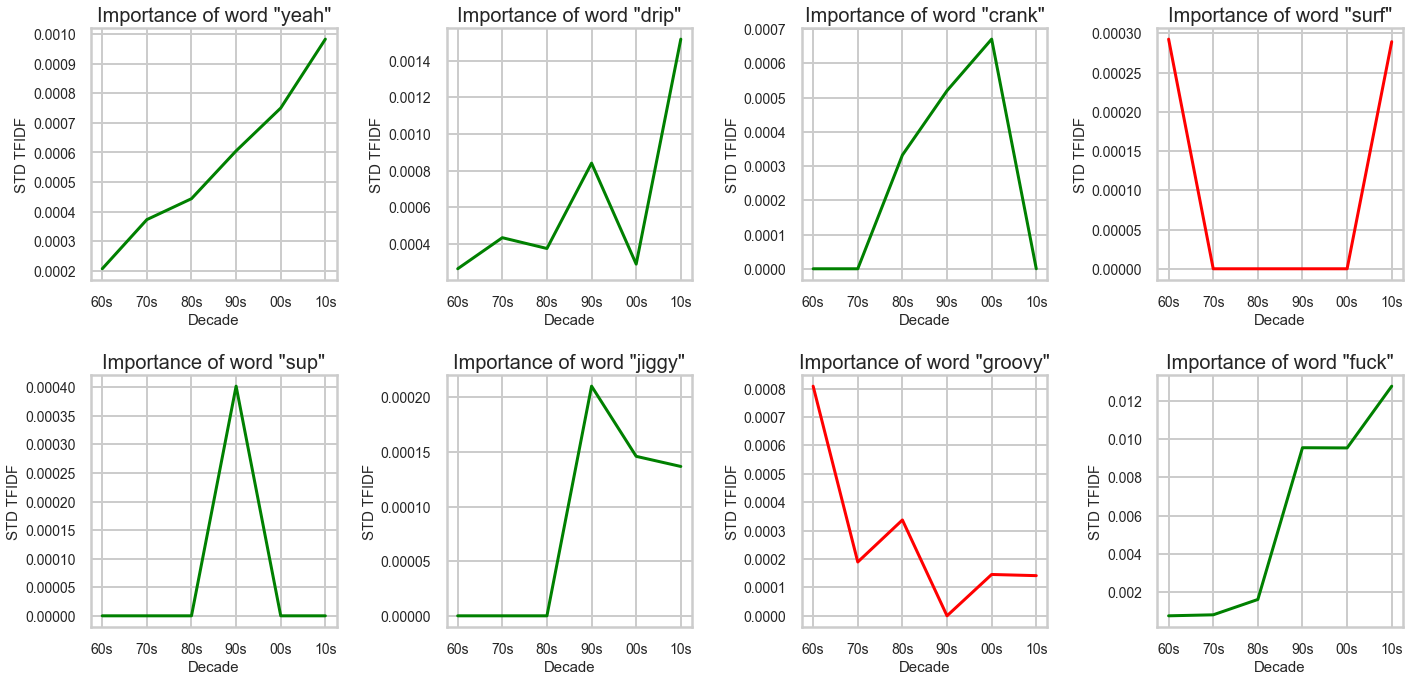

In [53]:
# some words notably belonging to different decades 
targets = ["yeah", "drip", "crank", "surf", "sup", "jiggy", "groovy", "fuck"]

fig, axs = plt.subplots(2,4,figsize=(20, 10))
axs = axs.flatten()
sns.set_theme(style = "whitegrid", palette= "twilight", context = "poster")

for i,target in enumerate(targets):
    coords = defaultdict(list)
    for d in ["60s", "70s", "80s", "90s", "00s", "10s"]:
        curr_decade =  all_tok_by_decade[all_tok_by_decade["decade"] == d]
        try:
            std_tfidf = curr_decade[curr_decade["word"] == target].tfidf.tolist()[0] / len(songs[songs["decade"] == d])
            # must standardize by number of songs available per decade in the dataset, otherwise all values always jump up in the
            # 10s, which has the majority of songs
            coords[d].append(std_tfidf) 
        except:
            coords[d].append(0)

    target_evol = pd.DataFrame(coords).T.rename(columns = {0: "tfidf"}).reset_index()

    if target_evol["tfidf"][0] > target_evol["tfidf"][5]:
        color = "red"
    else:
        color = "green"
        
    axs[i].plot(target_evol["index"], target_evol["tfidf"], color = color)
    axs[i].set_xlabel('Decade', fontsize=15);
    axs[i].set_ylabel(ylabel = "STD TFIDF", fontsize = 15);
    axs[i].set_title(f"Importance of word \"{target}\"", fontsize=20)
    axs[i].tick_params(axis='both', which= 'major', labelsize=14)
plt.tight_layout()

Naturally, to get more robust and meaningful results, ideally one should work with a greater and more balanced dataset. 

## <a name="3D"></a> 3D Representation

At this point, I wanted to someway visualize the difference between more recent and older songs lyrics. For this reason, I ran a TFIDF vectorizer on the lemma entries of the balanced dataset, then reduced dimensionality through [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization, extracted only songs from the chronological extremes, namely the 60s and 2010s, and finally plotted the result. We can indeed see the two clouds of points are separated in the space (though not in an excessively sharp way) implying there are differences between the terms used in the respective lyrics, and that the language in music today has changed since the 60s (at least according to this dataset).

In [98]:
# TFIDF Vectorization step

tokens = songs_bal.lemma.tolist()
X_tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   min_df=0.001,
                                   max_df=0.75, 
                                   stop_words='english', 
                                   sublinear_tf=True)

X_tfidf = X_tfidf_vectorizer.fit_transform(tokens)

In [99]:
# SVD Dimensionality reduction step

k = 3

svd = TruncatedSVD(n_components=k, random_state=1)
%time U = svd.fit_transform(X_tfidf)

CPU times: total: 250 ms
Wall time: 185 ms


In [100]:
# Storing the coordinates and the relative decade in a df

U3D_tfidf = pd.DataFrame(data = U, index = songs_bal.decade)
U3D_tfidf.head()

,0,1,2
decade,,,
10s,0.182980,-0.014312,-0.115608
00s,0.194208,0.008531,0.011091
70s,0.188111,-0.001675,0.085210
90s,0.078461,0.052403,0.010092
00s,0.237051,-0.074201,-0.070531


In [101]:
# Extracting only songs from the 60S and 10S

_10s = U3D_tfidf[U3D_tfidf.index == "10s"]
_60s = U3D_tfidf[U3D_tfidf.index == "60s"]

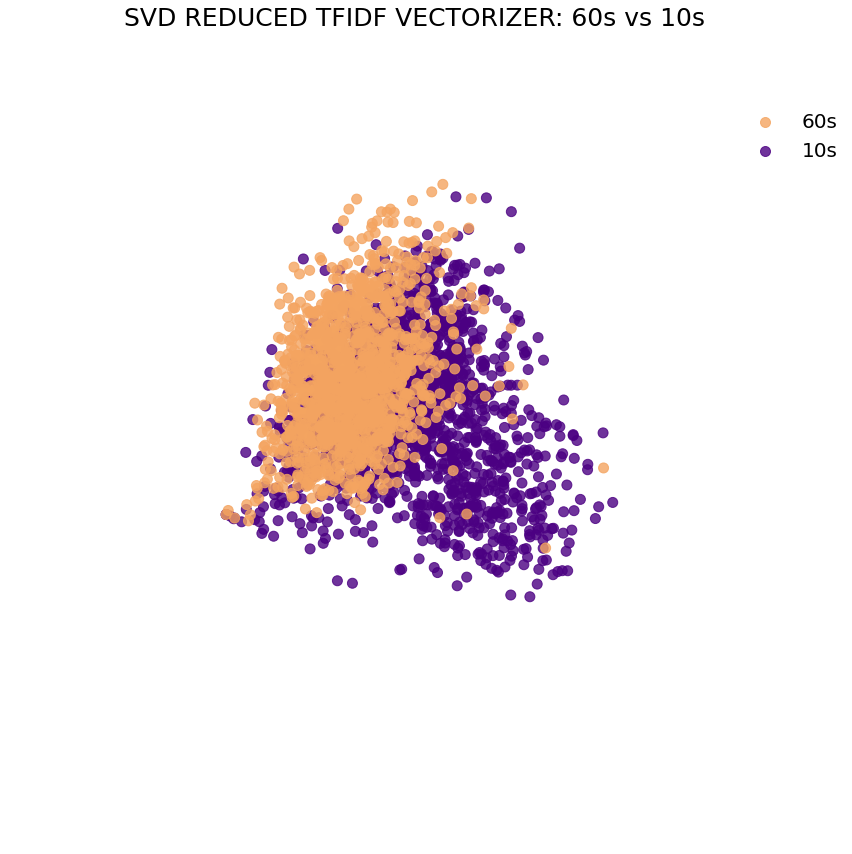

In [76]:
# Plotting the results

fig = plt.figure(figsize=(15,15))  
ax = fig.add_subplot(111, projection='3d')  

x60s, y60s, z60s = np.array(_60s.T)
x10s, y10s, z10s = np.array(_10s.T)

ax.scatter(x60s, y60s, z60s, c = "sandybrown", label = "60s", s = 100, alpha = 0.8)
ax.scatter(x10s,y10s,z10s, c = "indigo", label = "10s", s= 100, alpha = 0.8)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.view_init(elev= 300, azim= -950)
plt.legend(loc='lower right', prop={'size': 20},bbox_to_anchor=(0.04, 0.82, 1., .102), frameon = False )
plt.title("SVD REDUCED TFIDF VECTORIZER: 60s vs 10s", size = 25)
plt.axis("off")
plt.show()

## <a name="w2v"></a> W2V Embeddings

Following in this analysis, we can use embeddings to position words in a hyperspace given the context they are used in, and investigate where certain words lie with respect to each other as a measure of their similarity. This can be done for example to see if some notable differences emerge as time progresses, which could be linked to the nature of the songs and how certain topics are treated. The technique I used for this specific task was the [Word2vec](https://en.wikipedia.org/wiki/Word2vec) algorithm.

We can select a target word and in each row we substitute it with "target_decade", depending on the decade of the song, then train different Word2vec models, and finally average the results. Doing so we treat the same word across decades as different tokens, so each of them will be autonomously allocated in the hyperspace, allowing us to study how the meaning of some target tokens and their context changes with time.

For this task I used the balanced (downsampled) dataset, and specifically I decided to investigate how the figure of the woman evolves as time progresses, with the aim of unveiling potential rise of misogyny in music lyrics.

<div class="alert alert-block alert-danger">
<b>Please Note:</b>
    
* In no way this approach is meant to prove anything in such a delicate matter, it is just serves as a preliminary analisys to share some simple ideas of how NLP tools we have seen in class could be used in this field.

* I will also use explicit language which is in no way meant to disrespect anyone. 
</div>

In [8]:
# Choose a target word:

target = "girl"

tok_by_dec = songs_bal[["decade", "lemma"]].copy()
tok_by_dec = tok_by_dec[(tok_by_dec.decade != "50s") & (tok_by_dec.decade != "20s")] # only keep decades from 60s to 10s 

def split_tok_by_dec(row, target):
    """ 
    Substitute target word with target_decade in all lemmas of lyrics
    """
    
    decade = row["decade"]
    token_decade = re.sub(target, f"{target}_{decade}", row["lemma"])
    return token_decade

tok_by_dec["lemma"] = tok_by_dec.apply(lambda x: split_tok_by_dec(x, target), axis = 1)
print("Example:",tok_by_dec.loc[83,"lemma"])

Example: people people people people people people people people shippity bop well hot diggity iggity bum siggity niggas wanna know check flow little chickadee comin book kid look winner ya well get'cha plate servin rap dinner freak sewer quick ya posse swoop loop kamikaze see think lose spot go get real comfy got hit hard bogart humphrey ya hypocrite rippin flyer phony full bologna oscar mayer see attack pack rapper practice bust tactic sharp fucking cactus set set book reverse next kid sendin big borough thorough breed ed ghetto teenie bop takin lesson sweatin niggas graffiti rock slang bringer bring thing interpretation nerve achin see sick niggas perpetratin see screamin record beavis butthead bust head amy fisher piss hit accident town peep radisson splatterin batterin crew lip chatterin be new crew back back effect people people people people yo still wanna go check flow try bite fake nigga left ste right outta sight look blow diss anigga microphone cause bone sister word bond ne

In [9]:
# Define a function to "dense vectorize" documents

def w2v(songs, vector_size = 300, window = 10, seed = 10, epochs = 1000, negative = 20):
    """
    This function creates a dense vectorization for all the tokens in the input text through the Word2vec algorithm.
    """
    
    documents = songs.lemma.tolist()
    corpus = [document.split() for document in documents]

    w2v_model = Word2Vec(vector_size = vector_size, 
                         window = window, 
                         sample = 0.0001, 
                         epochs = epochs, 
                         negative = negative, 
                         min_count = 50,
                         workers = -1, 
                         hs = 0, 
                         seed = seed 
    )
    w2v_model.build_vocab(corpus)

    w2v_model.train(corpus, 
                    total_examples=w2v_model.corpus_count, 
                    epochs=w2v_model.epochs)
    return w2v_model

# train 3 word embeddings with different parameters

w2v_1 = w2v(tok_by_dec, seed = 987, window = 10, epochs = 500, negative = 5)
w2v_2 = w2v(tok_by_dec, seed = 654, window = 7, epochs = 500, negative = 10)
w2v_3 = w2v(tok_by_dec, seed = 321, window = 5, epochs = 500, negative = 20) 

In [10]:
# choose some words of interest 

words = ["lady", "miss", "friend", "honey", "sweet", "pretty", "baby", "babe", "love", "sex", "fuck", "bitch", "hoe", "whore"]

# average the vectors of the target words and the selected words of interest the 3 w2v and store results in avg_w2v

avg_w2v = {}
for i in tok_by_dec.decade.unique():
    try:
        avg_w2v[f"{target}_{i}"] = np.array([w2v_1.wv[f"{target}_{i}"],w2v_2.wv[f"{target}_{i}"], w2v_3.wv[f"{target}_{i}"]]).mean(axis = 0)
    except:
        print(f"{target} doeas not appear in lyrics from the {i}")
for word in words:
    try:
        avg_w2v[word] = np.array([w2v_1.wv[word], w2v_2.wv[word], w2v_3.wv[word]]).mean(axis = 0)
    except:
        print(f"{word} does not appear in the corpus!")
        
# convert dictionary in a df

avg_w2v = pd.DataFrame(avg_w2v).T
avg_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
girl_70s,0.000618,-0.000112,0.001217,-0.001330,-0.001668,-0.000609,0.000855,-0.001463,-0.000210,0.001114,...,0.002074,-0.001324,0.000799,0.000891,0.002154,0.000927,0.000242,0.000003,0.000371,0.002040
girl_90s,0.001166,0.000067,-0.001232,-0.000671,0.000337,-0.000232,-0.000301,-0.000977,-0.000039,-0.000712,...,-0.000844,0.001137,-0.002193,-0.002771,-0.001698,-0.001256,0.000560,0.000869,0.001276,0.002879
girl_10s,0.000765,-0.000831,-0.000109,0.001350,0.000114,-0.002251,0.002135,0.000161,0.000547,-0.001168,...,-0.002551,-0.000519,-0.001760,0.000753,-0.002228,-0.000518,0.001202,0.001320,0.002603,-0.001490
girl_80s,0.000015,0.002072,-0.000998,-0.001063,-0.001337,0.000122,0.001293,0.000335,0.000100,-0.000749,...,-0.000599,0.002415,0.000083,0.001620,0.000552,0.000119,0.001447,0.000280,-0.001031,0.000373
girl_60s,-0.000607,0.000291,0.000631,0.000240,-0.000191,0.001559,-0.001151,0.000459,-0.000288,0.000921,...,-0.000318,-0.001677,-0.000183,0.001142,0.001373,0.000582,-0.001366,0.001065,0.000428,-0.001204


Words were chosen to become progressively more intimate and ultimately just gross and offensive. Although experimenting with different seeds and parameters results can vary quite a lot, luckily there doesn't seem to be a clear trend towards progressively more misogynist lyrics, or rather, this naive method applied to this dataset is not observing such tendency. It should be noted however that it is slightly more likely that more vulgar words appear in the context of "girl" in the more recent half of the decades, which itself could be an alarming sign of an emerging phenomenum in contemporary music.

In [11]:
def similar_by_dec_avg(w2v, w1, w2):
    """
    See in which decade the target word w2 is more similar to another word of interest w1
    """

    dec = f"Token {w1} never appears in the corpus!"
    cos_sim = -np.inf 
    for i in tok_by_dec.decade.unique():
        w2_dec = f"{w2}_{i}"
        try:
            dec_sim = np.dot(w2v.loc[w2_dec,:], w2v.loc[w1,:])/(np.linalg.norm(w2v.loc[w2_dec,:])*np.linalg.norm(w2v.loc[w1,:]))
            # compute cosine similarity
            
            if dec_sim > cos_sim:
                cos_sim = dec_sim
                dec = f"{w2} and {w1} are most similar in the {i}" 
        except:
            pass
        
    return dec

print("When are the words most similar?")
print()

for word in words:
    print(similar_by_dec_avg(avg_w2v, word, target))

When are the words most similar?

girl and lady are most similar in the 60s
girl and miss are most similar in the 00s
girl and friend are most similar in the 80s
girl and honey are most similar in the 70s
girl and sweet are most similar in the 70s
girl and pretty are most similar in the 10s
girl and baby are most similar in the 10s
girl and babe are most similar in the 00s
girl and love are most similar in the 60s
girl and sex are most similar in the 00s
girl and fuck are most similar in the 10s
girl and bitch are most similar in the 90s
girl and hoe are most similar in the 00s
girl and whore are most similar in the 90s


We can try and visualize these results reducing the dimensions of the averaged w2v through [TSNE](https://it.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), and then plotting the words. 

In [13]:
def plot_vectors(vectors, title='VIZ', labels= None, instance_id = None, dimensions = 2):
    """
    Plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    if instance_id is not None:
        df['instance_id'] = instance_id
    else:
        df['instance_id'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('hsv') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

        for x, y, z, i in zip(df.x, df.y, df.z, df.instance_id):
            ax.text(x, y, z, i, size=1)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.7, 
                       s=100)

        for x, y, i in zip(df.x, df.y, df.instance_id):
            ax.text(x, y, i, size=15)

            
    else:
        raise NotImplementedError()
 
    plt.title(title)

<div class="alert alert-block alert-danger">
<b>Stochasticity Alert:</b>
The following comments will be related to the plot below. Despite having set a random state, results may vary with new runs.
</div>

Again, the outcome is highly subjected to stochasticity, but usually the more offensive words appear closer to each other and to the later decades. Below, for example, offensive words fall in the upper portion of the space. Across different trials it seems like the word "girl" is mostly associated to "sex" and "bitch" in the 90s and 00s. Weirdly, the token girl_60s often falls in this area as well, which may indicate how these results, as thought provoking as they may be, are also someway unreliable.

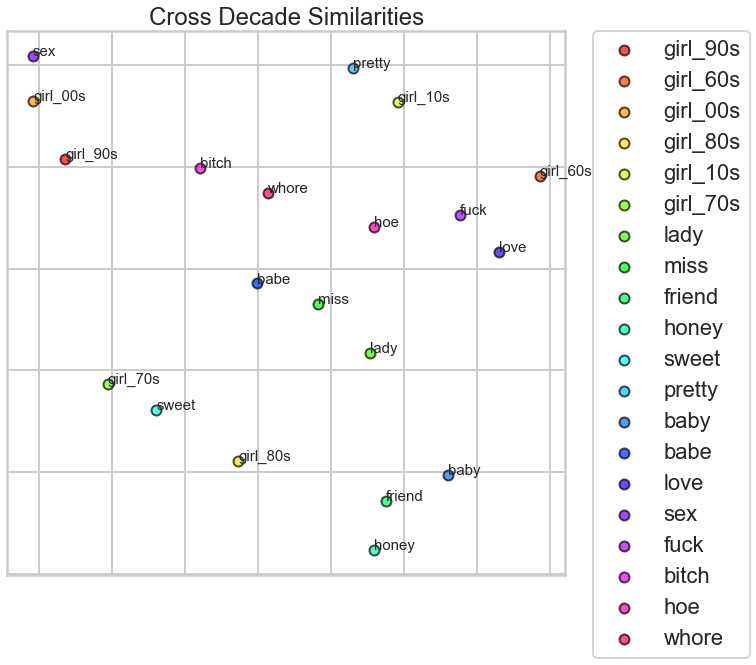

In [264]:
# apply TSNE and reduce to 2 dimensions

avg_w2v_2D = TSNE(random_state = 1, metric = "cosine", perplexity = 5).fit_transform(avg_w2v)

plot_vectors(avg_w2v_2D, title = "Cross Decade Similarities", labels = avg_w2v.index,instance_id = avg_w2v.index, dimensions=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## <a name="doc2vec"></a> Document Embeddings and Gender Analysis

So far I've been considering tracks of all artists alike, but to investigate this matter it could make sense to control for the gender of the artist as well, to see if systematic differences exist in the lyrics. For this purpose I extracted genders through the [MusicBrainz](https://musicbrainz.org/) online database, which provides an API. Below is the simple function used, as well as the updated dataset ready to be imported.

In [74]:
import musicbrainzngs
import time

In [390]:
# very straigh forward creation of an app
# musicbrainzngs.set_useragent("My NLP Project", "v2")

In [391]:
def extr_gender(x):
    """
    For each song title given as input, this function returns the gender of the artist, "group" if the song was performed by
    a group, and finally "unknown" if the data is not available in the database.
    """
    time.sleep(1) # to avoid exceeding the rate limit
    result = musicbrainzngs.search_artists(artist=x)
    i = 0
    while i < 3: # try 3 times
        try:
            type_ =  result["artist-list"][0]["type"]
            if type_ == "Person":
                try:
                    return result["artist-list"][i]["gender"]
                except:
                    i += 1    
            elif type_ == "Group":
                return "group"
            else:
                return "unknown"
        except:
            return "unknown"

In [392]:
# total running time ~4 hours, please run directly next cell to import the alreadyupdated dataframe
#songs["gender"] = songs.track_artist.apply(lambda x: extr_gender(x))

In [23]:
# importing dataframe with new column "gender" obtained from the MusicBrainz database
songs_gender = pd.read_csv("data/song_gender").drop(columns = "Unnamed: 0").fillna("unknown")
songs_gender.head()

,ID,track_name,track_artist,lyrics,lemma,genre,language,release_date,decade,danceability,energy,loudness,acousticness,instrumentalness,valence,gender
0,0,Love Scars,Trippie Redd,"ayy lil 14, yeah you used to say you in love i...",ayy lil use say love use say shit takin shit h...,rap,en,2017-05-14,10s,0.659000,0.614000,-7.320000,0.000404,0.000000,0.260000,male
1,1,Kiss It Better - KAYTRANADA Edition,Rihanna,"kiss it, kiss it better, baby kiss it, kiss it...",kiss kiss well baby kiss kiss well baby waitin...,r&b,en,2016-06-01,10s,0.854000,0.498000,-7.922000,0.022900,0.000212,0.343000,female
2,2,Happy,Oh Wonder,never thought i'd be happy never thought i'd b...,never think happy never think happy think see ...,pop,en,2020-01-03,20s,0.698000,0.516000,-8.472000,0.454000,0.000000,0.516000,group
3,3,never dreamed you'd leave in summer,joan baez,i never dreamed you'd leave in summer i though...,never dream leave summer think go come back ho...,pop,en,1975,70s,0.181198,0.232208,0.604928,0.764056,0.000000,0.153957,female
4,4,Did My Best,The Voidz,let me tell you a story'bout the hazy good old...,let tell story'bout hazy good old day change g...,rock,en,2019-12-13,10s,0.533000,0.794000,-4.687000,0.154000,0.888000,0.623000,group


In [24]:
def non_binary(x):
    """
    This function identifies non-binary persons from the data obtained from the MusicBrainz database 
    """
    if x == "other" or x == "not applicable":
        return "non-binary"
    elif x == "unkown":
        return "unknown" # small typo 
    else:
        return x
    
songs_gender.gender = songs_gender.gender.apply(lambda x: non_binary(x))

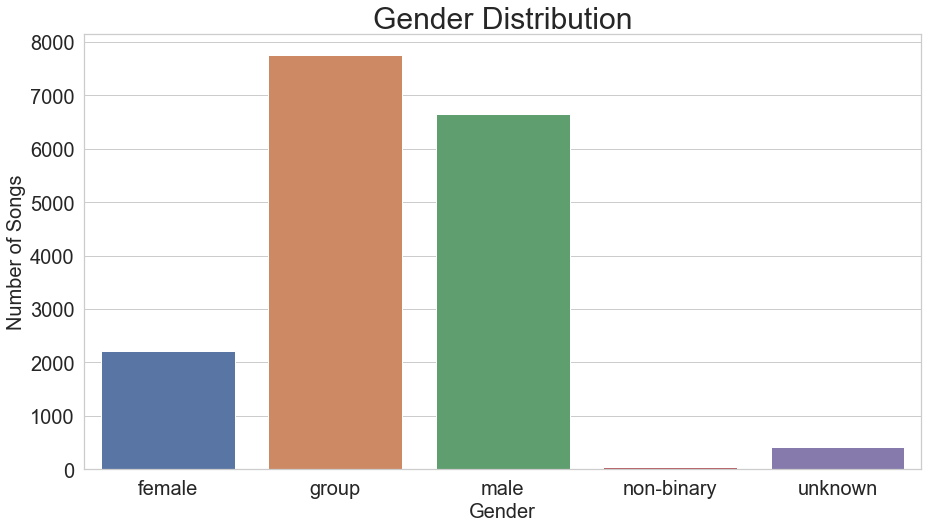

In [25]:
# Plot the distribution of genders in the dataset
songs_gender_count = songs_gender.groupby(by = ["gender"]).count().reset_index()
sns.set(rc={'figure.figsize':(15,8)})
sns.set_theme(style = "whitegrid")

ax = sns.barplot(x = "gender", y = "ID", data = songs_gender_count, dodge=True)

plt.xlabel('Gender', fontsize=20);
plt.ylabel('Number of Songs', fontsize=20);
plt.title("Gender Distribution", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
print()

My aim was to use the [doc2vec](https://en.wikipedia.org/wiki/Word2vec#doc2vec) algorithm tagging each song by the gender of its artist (more precisely if male, female, non binary or a group) and then see how similar some target words were to the gender tag, and see if it is true that some words are more feminine or masculine than others. Due to the heavy under representation of the non-binary persons, I decided to drop them for this analysis.

In [26]:
# Very unbalanced, so I will limit to the number of males and groups, and due to the heavy lack of data I will also exclude
# non binary artists for the following analysis

m = songs_gender[songs_gender["gender"] == "male"]
f = songs_gender[songs_gender["gender"] == "female"]
g = songs_gender[songs_gender["gender"] == "group"]
nb = songs_gender[songs_gender["gender"] == "non-binary"]

print("Number of non-binary persons in current dataset:",len(nb))
sample_gender = pd.concat([m,f,g]).sample(frac = 1)

Number of non-binary persons in current dataset: 46


In [27]:
def doc2vec(df, label_, vector_size = 300, window = 10, seed = 10, epochs = 500, negative = 20):
    """
    This function creates a dense vectorization of documents using the Doc2vec algorithm
    """
    
    corpus = []
    for row in df.iterrows():
        label = row[1][label_]
        text = row[1].lemma
        corpus.append(TaggedDocument(words=text.split(), 
                                     tags=[str(label)]))

    print('done')
    # initialize model
    d2v_model = Doc2Vec(vector_size=vector_size, 
                        window=window,
                        hs=0,
                        sample=0.000001,
                        negative= negative,
                        min_count=100,
                        workers=-1,
                        epochs=epochs,
                        dm=0, 
                        dbow_words=1,
                        seed = seed)

    # build the vocabulary
    d2v_model.build_vocab(corpus)

    # train the model
    d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
    
    return d2v_model

In [28]:
def cosine(word1, word2, df):
    """
    This function returns the cosine similarity between two vectors
    """
    return np.dot(df.loc[word1,:], df.loc[word2,:])/(np.linalg.norm(df.loc[word1,:])*np.linalg.norm(df.loc[word2,:]))

In [48]:
d2v_model = doc2vec(sample_gender, "gender", vector_size = 200, window = 10, seed = 0, epochs = 500, negative = 20) #1 6

done


In [49]:
# dataframe with doc tag embeddings
d2v_df_tags = pd.DataFrame([d2v_model.dv[n] for n in range(len(d2v_model.dv.index_to_key))], 
                             index = [i.upper() for i in d2v_model.dv.index_to_key])

# dataframe with word embedding (produced by d2v method)

d2v_df_words = pd.DataFrame([d2v_model.wv.get_vector(n)
                             for n in d2v_model.wv.key_to_index],index=d2v_model.wv.key_to_index)
d2v_df = pd.concat([d2v_df_tags, d2v_df_words])
d2v_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
MALE,-0.000945,0.001218,0.001596,-0.001792,-0.000940,0.000627,-0.004526,-0.004171,0.001314,0.001990,...,-0.004502,0.000264,-0.001713,-0.003171,-0.001370,0.004454,0.000431,0.001168,-0.003955,-0.004222
GROUP,-0.004342,-0.004133,0.001334,-0.001674,0.002074,-0.004791,-0.001837,0.004946,-0.002641,0.002918,...,-0.000387,0.001493,0.000679,-0.001309,-0.003813,-0.004868,-0.001069,-0.004046,0.001655,0.002438
FEMALE,0.000213,0.003672,-0.002994,-0.001404,0.003779,0.003067,-0.003321,0.000386,-0.002757,0.003694,...,-0.002989,-0.000323,0.001423,0.003764,0.003261,0.002112,-0.002072,0.004802,-0.004759,-0.002263
get,0.003506,0.001370,0.000111,-0.002302,-0.001922,-0.004590,-0.004248,-0.004835,-0.003247,0.003133,...,0.003274,0.004572,-0.001397,-0.003512,0.000169,0.004726,-0.001328,0.003899,-0.001162,0.003224
know,-0.002704,-0.000200,-0.001732,-0.002676,0.003927,0.003019,-0.003603,0.004235,0.004710,-0.002339,...,-0.004642,0.000714,-0.000529,-0.004936,0.000436,0.002726,0.002415,0.004783,0.000291,0.000899


I was curious to see whether it is true there are some themes that are more "manly" or "girly", as maybe male artists are more likely to sing about cars luxuries and violence, and maybe in a more vulgar way, whereas female artists are more prone to singing about love and are more sentimental and emotional. 

I chose to use cosine similarity to account for the fact that there are less songs written by female artists in my dataset, as this measure should capture similarity without being too affected by this.

It turns out that repeating the "experiment" with  different seeds and parameters these prejudices and biases are are almost never met, and although violent words like "kill" are usually more associated with male artists, the word "love" for example is equally associated to male and female artists alike,  often profanity terms are more similar to the female tag, and in general there are no systematic differences between genders emerging.

This experiment should be repeated with more data to gather new insights on the matter.

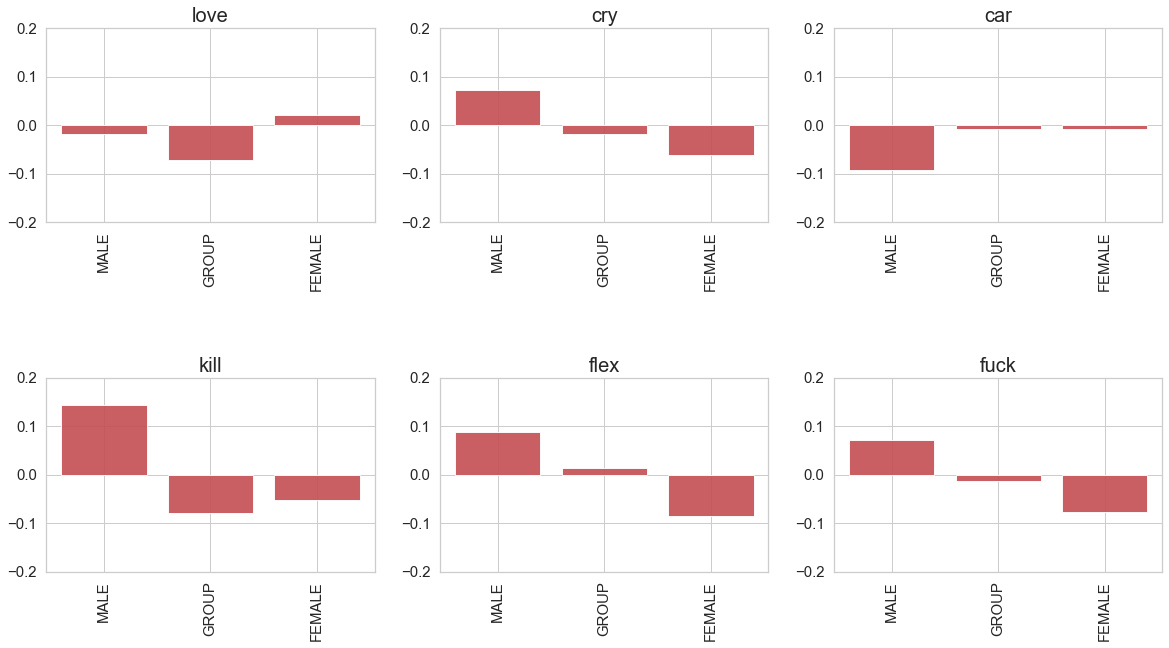

In [50]:
subplots = [231, 232, 233, 234, 235, 236]
tag_doc_list = [i.upper() for i in d2v_model.dv.index_to_key]
topics_words = ["love", "cry", "car", "kill", "flex", "fuck"]
fig = plt.figure(figsize=(20, 10))  
for i in range(len(subplots)):
    ax = fig.add_subplot(subplots[i])
    co = []
    for tag in tag_doc_list:
        co.append(cosine(tag, topics_words[i],d2v_df))
    plt.bar(tag_doc_list, co, color = "r", alpha = 0.9)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(rotation = 90)
    plt.title(topics_words[i], fontdict = {'fontsize': 20})
    plt.ylim([-0.2, 0.2])
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)

## <a name="topic"></a> Author Topic Model

Now we can use topic models to see if some recurrent topics can be identified. This was done using Author Topic Models, an extension to the [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) model.In particular, we tag each song by its decade, and then can investigate how the distribution of topics varies with time, i.e. if new themes make an appearence and if others become outdated. Again I've decided to use the balanced dataset to avoid that the 10s have a too strong of an influence over the results.

In [34]:
instances = [s.split() for s in songs_bal.lemma] # list of lists containing words of each comment
print("creating dictionary", flush = True)
 
phrases = Phrases(instances, min_count = 5, threshold = 1) # from instances create dict obj that stores info about freq etc
instances_colloc = phrases[instances] # store info about words and collocations
dictionary = Dictionary(instances_colloc) # and use it to create my dictionary

dictionary.filter_extremes(no_below = 50, no_above = 0.5) # get rid of words that are too rare or too frequent
print(dictionary, flush=True)

print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] # replace words by their numerical IDs and their frequency

print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus) # this object learns and stores TFIDF values from corpus 

model_corpus = tfidfmodel[ldacorpus] # transform raw frequencies into TFIDF

print("Done")

creating dictionary
Dictionary(1867 unique tokens: ['be_one', 'find', 'going', 'night', 'round']...)
translating corpus to IDs
tf-idf transformation
Done


In [35]:
# Specify some category with respect to which find topics
target_category = "decade" 

author2doc = defaultdict(list) # mapping from decade to document
# create a dictionary whose value is a list
for i, artist in enumerate(songs_bal[target_category]):
        author2doc[artist].append(i)

To support the decision of the appropriate number of topics we can rely on some scores of "coherence" of the results evaluated at different possible values, to see which are more reliable. Moreover, I used an alpha of 0.8 as I assume that songs can touch on multiple topics.

In [721]:
# Compute some measures of coherence for different values of k (number of topics)
coherence_values = []
author_model_list = []

dev_size = len(ldacorpus)

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(1, 10):
    author_model = AuthorTopicModel(corpus=list(ldacorpus[:dev_size]), 
                                    author2doc=dev_author2doc,
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.8,
                                    random_state = 28
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

1 -1.0274730882359784 0.3687975721686635
2 -1.0625577019880672 0.361370602854994
3 -1.1996086275848077 0.345748703058951
4 -1.1300805927578095 0.36157736217044
5 -1.1150668083141015 0.35642717465478196
6 -1.0411012377394198 0.35456584671940217
7 -1.175789939438159 0.3465022782031661
8 -1.2174423045934666 0.34751470870619494
9 -1.3069707795812593 0.341803346941268


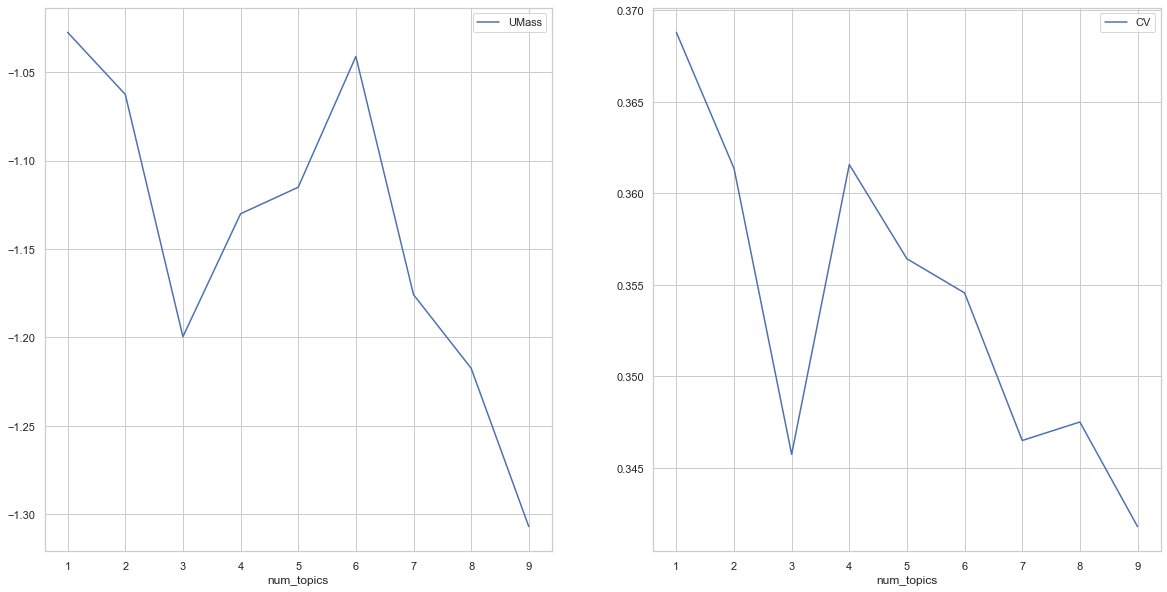

In [722]:
# Plot the results to choose optimal k
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1,10));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1,10));

<div class="alert alert-block alert-danger">
<b>Stochasticity Alert:</b>
The following comments will be related to the plot below. Despite having set a random state, results may vary with new runs.
</div>

It seems 4 to 6 could be a reasonable range to investigate. I believe more meaningful results are obtained with 4 topics.

In [36]:
# Run the definitive topic model
n_topics_author = 4
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

author_model = AuthorTopicModel(corpus = list(ldacorpus), 
                                author2doc = author2doc, 
                                id2word = dictionary, 
                                num_topics = n_topics_author,
                                passes = num_passes,
                                chunksize = chunk_size,
                                alpha = 0.8,
                                random_state = 28
)

522.95


In [40]:
# Extract top words per token
topic_sep = re.compile("0\.[0-9]{3}\*")

# extract a list of tuples with topic number and descriptors from the model
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=13)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:13]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))
    
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }

for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

1 "go", "let", "wanna", "baby", "come", "nigga", "want", "fuck", "say", "shit", "see", "make", "back"
2 "love", "go", "away", "la", "time", "long", "day", "come", "heart", "see", "find", "people", "cry"
3 "vibe", "rhythm", "love", "dance", "baby", "tell", "wanna", "people", "hit", "heaven", "even", "na", "find"
4 "love", "baby", "make", "say", "give", "come", "go", "never", "let", "want", "going", "right", "take"


Some pretty meaningful results can be extracted by these topics and the respective distributions plotted below:  
- The first bag of words contains several curse words as well as slang terms which can easily be linked to black culture and hip hop and in fact, after 30 years where it was basically non existent, the topic clearly emerges in the 90s and stays pretty present ever since;
- The second bag of words is more related to love songs, in a someway "intimate" manner, with words like heart, time and cry, and interestingly, the popularity of this genre has slowly decreased over the last 60 years;
- In the third bag of words we can find multiple tokens describing the musicality and dancing, and given its explosion in the 10s, it is likely connected to the craze of EDM music;
- Finally, the last bag of words is a more generic pop-ish song type, and in fact remains quite stably the dominant topic.

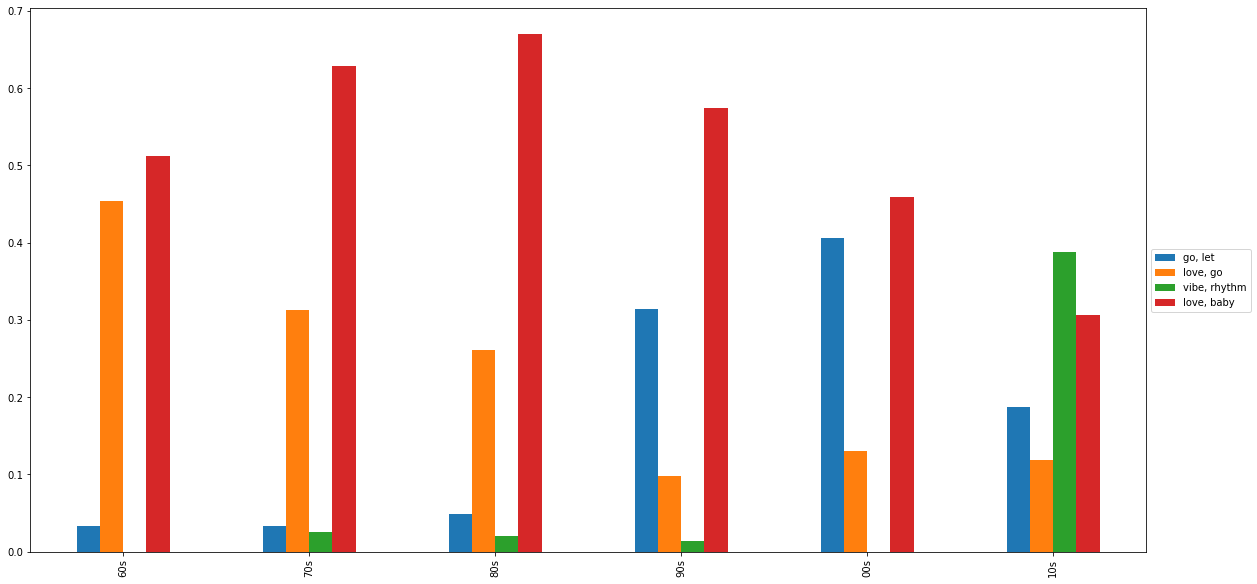

In [39]:
# Make a DataFrame
author_df = pd.DataFrame.from_dict(author_vecs)
author_df = author_df[["60s", "70s", "80s", "90s", "00s", "10s"]] # sort x axis

# Plot the distribution of topics across decades 
fig, ax = plt.subplots(figsize=(20,10))
author_df.T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));